# [Mood] Exploratory Data Analysis

In [1]:
import os
import csv
import json
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from tqdm import tqdm

from collections import defaultdict
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [2]:
DATA_PATH = '../data/'
MELSPECS_DIR = DATA_PATH + 'mood-melspecs-4544/'
SPLITS_DIR = DATA_PATH + 'mood-splits/'

# 1. Loading Splits



In [3]:
# Loading the label map
with open(DATA_PATH + 'mood_label_map.json', 'r') as output:
    label_map = json.load(output)

inv_label_map = {v: k for k, v in label_map.items()}

In [4]:
subsets = ['train', 'val', 'test']
X_filenames_list, one_hot_y_list = [], []

for subset in subsets:
    X_filenames_list.append(np.load(SPLITS_DIR + f'base/X_{subset}_filenames.npy'))
    one_hot_y_list.append(np.load(SPLITS_DIR + f'base/one_hot_y_{subset}.npy'))

In [5]:
len(one_hot_y_list[0])

3635

# 2. Plotting Tags Frequencies

In [8]:
def decoder(y_instance, label_map):
    idx = [i for i, value in enumerate(y_instance) if value == 1]
    tags = [v for k, v in label_map.items() if k in idx]
    return tags

def plot_tags_repartition(y, label_map, title):
    occ = defaultdict(int)
    for instance in y:
        tags = decoder(instance, label_map)
        for tag in tags:
            occ[tag] += 1

    df_occ = pd.DataFrame.from_dict(occ, orient='index', columns=['frequency']).sort_index(axis=0)

    # Plot
    ax = df_occ.sort_values(by='frequency', ascending=False).plot(kind='bar', figsize=(16,6), title=title)
    for i in ax.patches:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(x=i.get_x() - 0.15, y=i.get_height() + 2, s=str(i.get_height()), fontsize=10, color='dimgrey')
    
    save_title = '_'.join(title.lower().replace(',', '').replace('.', '').split(' '))
    plt.savefig(DATA_PATH + save_title + '.png')
    return df_occ

## Base split

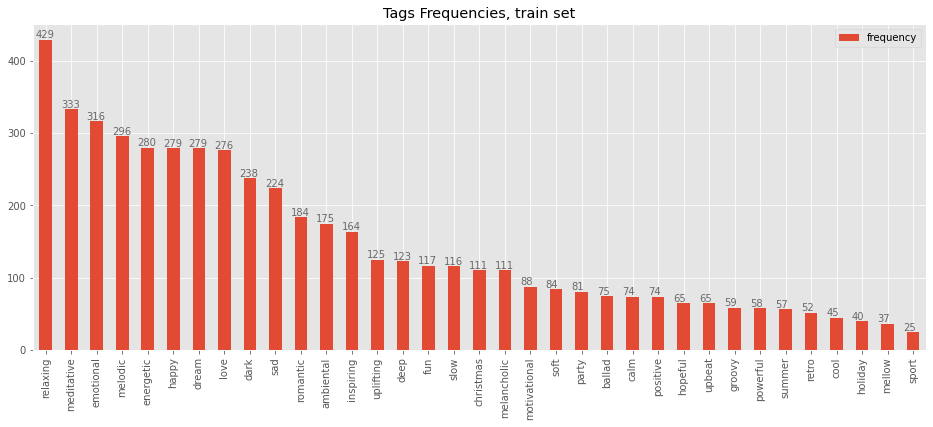

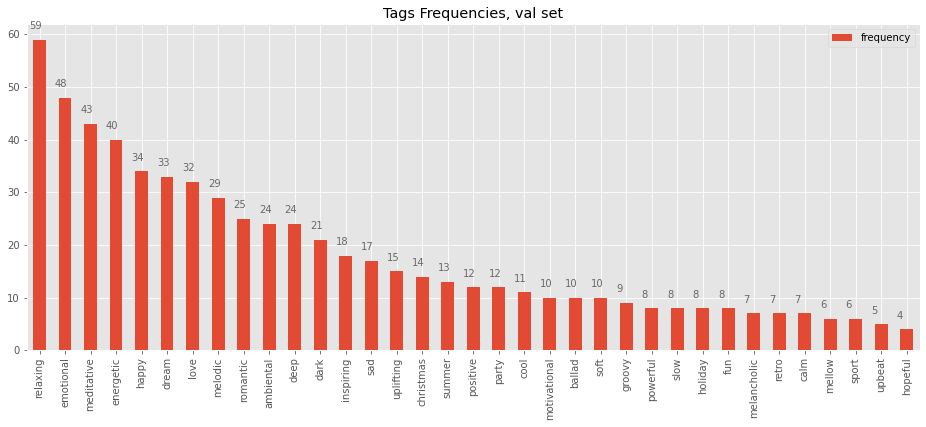

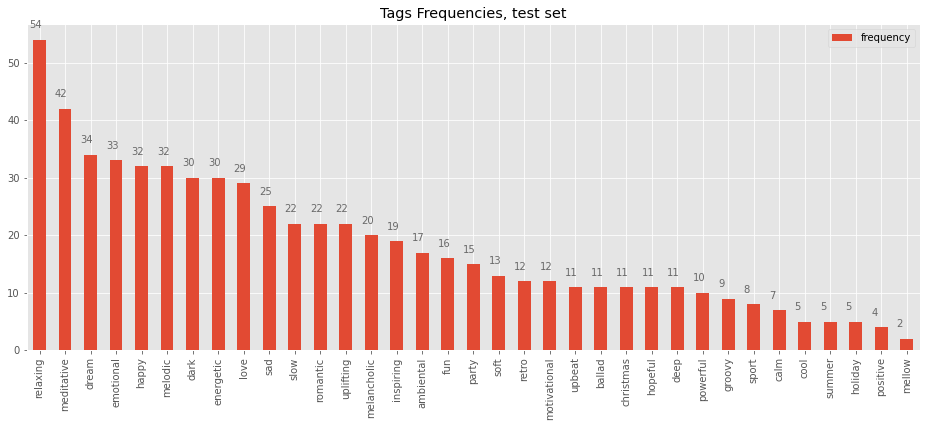

In [9]:
for y, subset in zip(one_hot_y_list, subsets):
    plot_tags_repartition(y, inv_label_map, title=f'Tags Frequencies, {subset} set')

## Method 1 — Oversample minority classes

In [13]:
sizes = [0.25, 0.5, 0.75, 1]

4931
7887
11279
15015


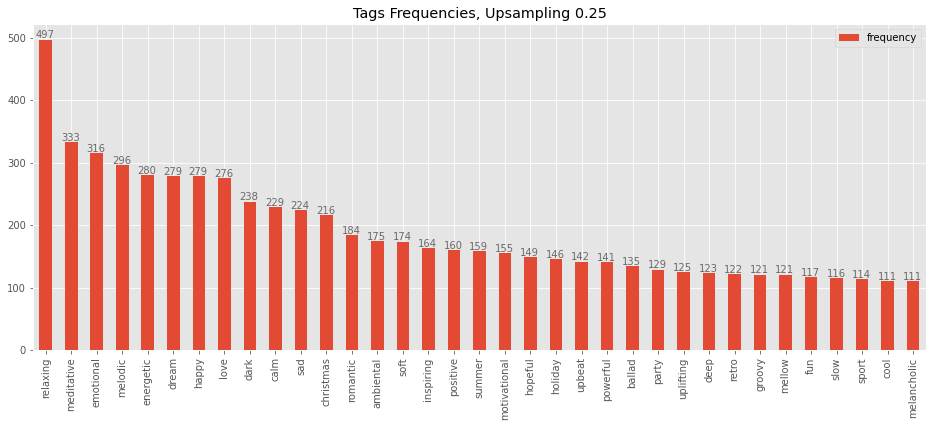

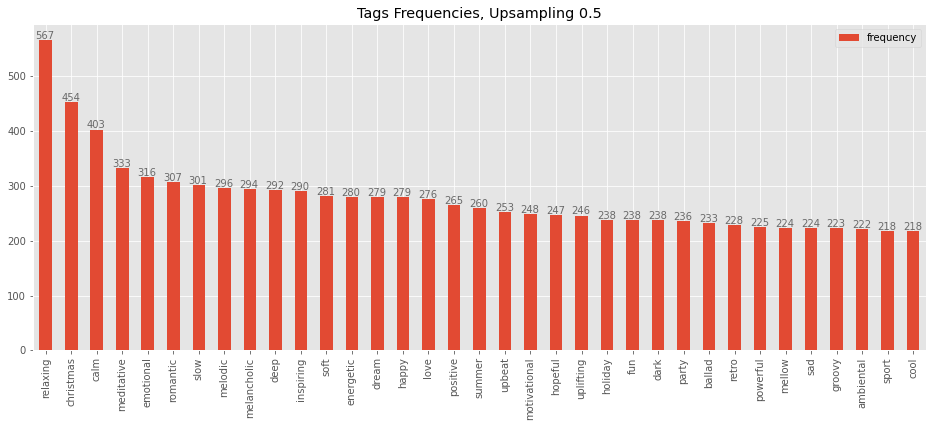

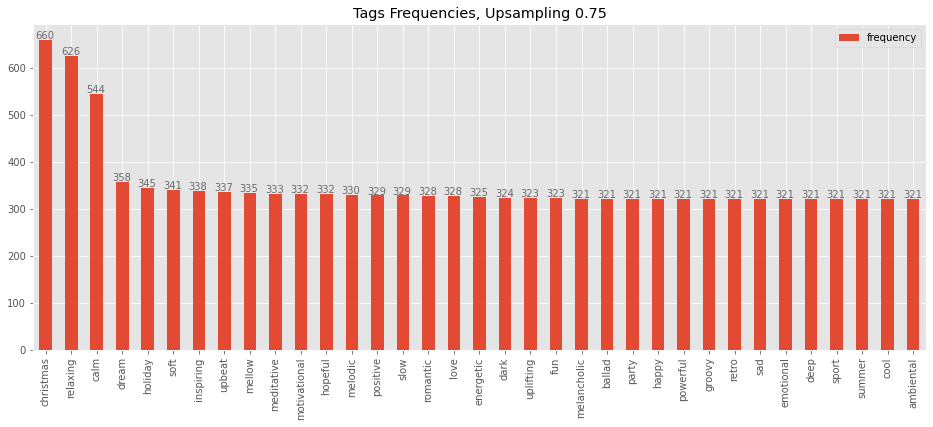

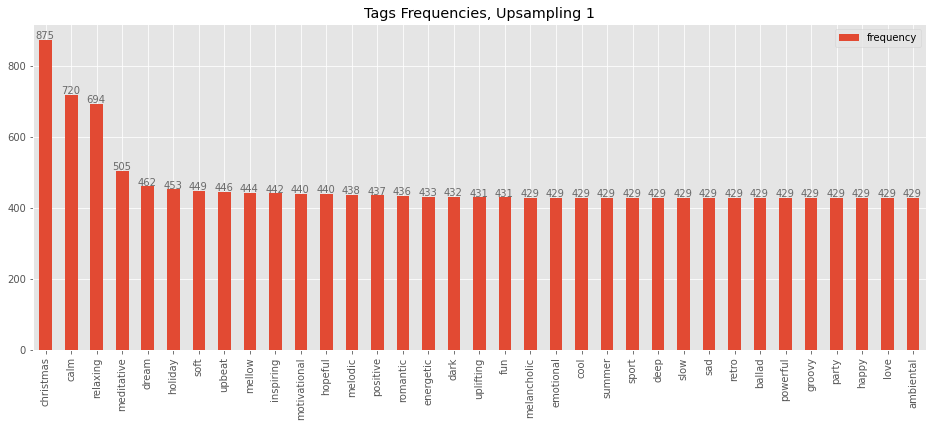

In [30]:
for size in sizes:
    one_hot_y_train_upsample = np.load(SPLITS_DIR + f'upsampling/one_hot_y_train_upsample_{size}.npy')
    print(len(one_hot_y_train_upsample))

    plot_tags_repartition(one_hot_y_train_upsample, inv_label_map, title=f'Tags Frequencies, Upsampling {size}')

## Method 2 — Undersample majority classes

3293
2270
1341
875


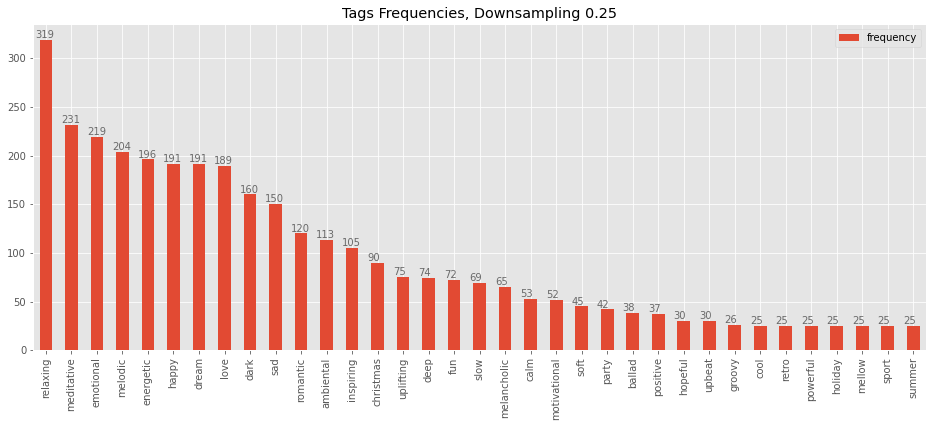

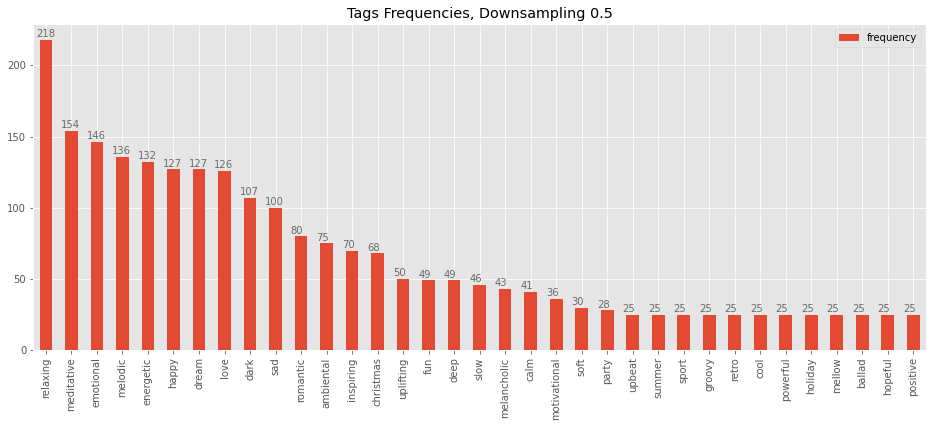

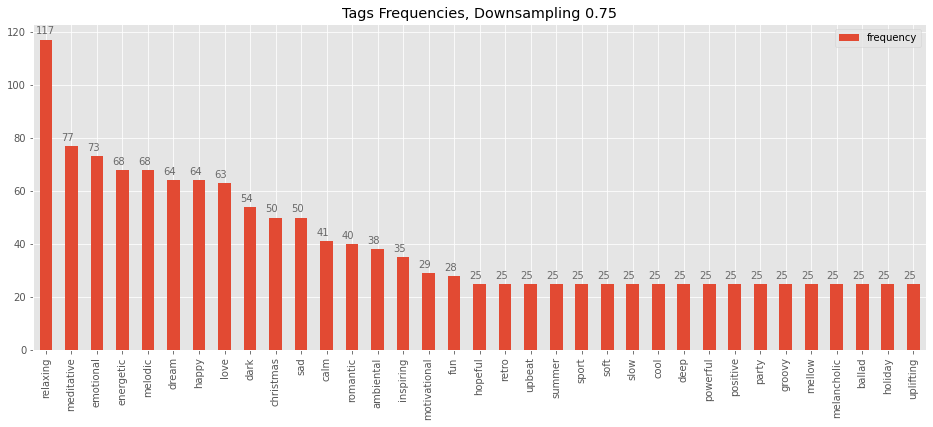

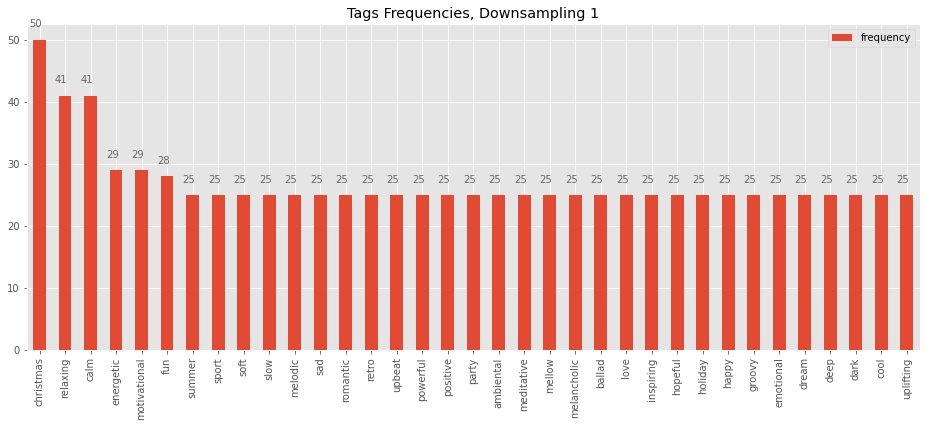

In [31]:
for size in sizes:
    one_hot_y_train = np.load(SPLITS_DIR + f'downsampling/one_hot_y_train_downsample_{size}.npy')
    print(len(one_hot_y_train))
    
    plot_tags_repartition(one_hot_y_train, inv_label_map, title=f'Tags Frequencies, Downsampling {size}')

# 3. Plot Co-occurrences

- Sorted by most frequent labels
- Shows most frequent labels and how they co-occur

In [10]:
one_hot_tags = pd.read_csv(DATA_PATH + 'mood_melspecs_metadata.csv')
one_hot_tags

,Unnamed: 0,filename,ambiental,ballad,calm,christmas,cool,dark,deep,dream,...,relaxing,retro,romantic,sad,slow,soft,sport,summer,upbeat,uplifting
0,0,12100.0.melspec.npy,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,12100.1.melspec.npy,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,12100.2.melspec.npy,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,12100.3.melspec.npy,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,12100.4.melspec.npy,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4539,4539,1420702.3.melspec.npy,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
4540,4540,1420704.0.melspec.npy,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4541,4541,1420704.1.melspec.npy,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4542,4542,1420704.2.melspec.npy,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
one_hot_tags = one_hot_tags.iloc[:, 2:]

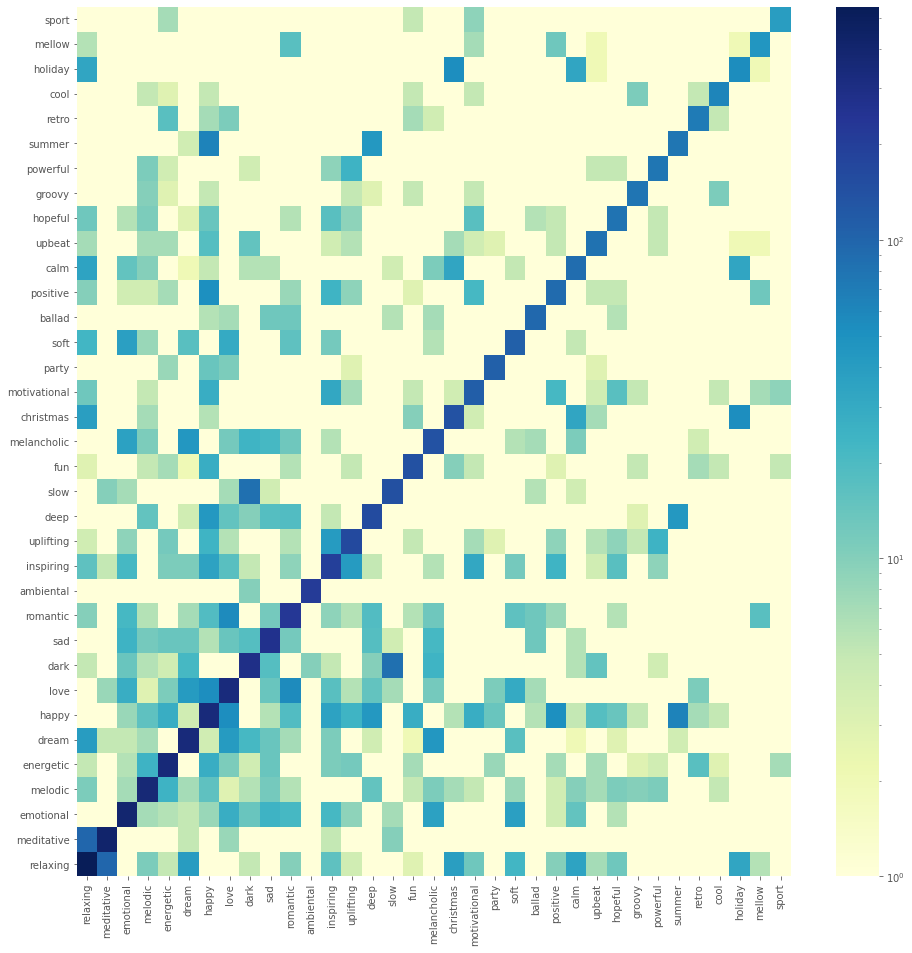

In [12]:
# calculate co-occurencies
coorc = one_hot_tags.T.dot(one_hot_tags)

# sort co-occurrence matrix
coorc = coorc.loc[coorc.max().sort_values(ascending=False).index]
coorc = coorc[coorc.max().sort_values(ascending=False).index]

# scale heat-map color encoding logarithmically
from matplotlib.colors import LogNorm

# shift by one to avoid log-domain error
coorc += 1

vmin = coorc.min().min()
vmax = coorc.max().max()

log_norm   = LogNorm(vmin=vmin, vmax=vmax)
cbar_ticks = [np.power(10, i) for i in np.arange(np.floor(np.log10(vmin)), 1+np.ceil(np.log10(vmax)))]

# plot
fig = plt.figure(figsize=(16,16))
ax = sns.heatmap(coorc, annot=False, cmap="YlGnBu", fmt='g', norm=log_norm, cbar_kws={"ticks": cbar_ticks});
ax.invert_yaxis()